**Other04 168-168 wavenet model to compare(not necessary,only for watching and compare)(PS:Download on the server offer by the match organization is prohibit,so the effect of code is only can be showed by screenshot of running on server.)**

**The memory usage is greatly improved, especially in sequence-to-sequence mode, the predicted label matrix is (n_sample, n_step, n_pred), n_sample will increase by 24 times, and n_pred will be reduced to 1/24 to cancel each other out, but n_step from 168 to 21 saves memory significantly. In the actual 1V10 situation of 168-168, the training set needs to be greatly reduced to run the sequence to the sequence mode.(screenshot shown in the end of code).Similar to the attention mechanism, which directly divides the characteristic attributes from period to period to the model, the training error is smoother, the convergence is faster, and the prediction is more accurate. Compared with the wavenet model using 168 hours -168 hours under the same conditions, the score is only 0.2665.(screenshot shown in the end of code)**

**168-168模型效果对比（不重要，只是为了观察和比较）（备注：因赛事方比赛服务器限制所有下载，部分代码效果只有对服务器代码运行截图显示，参见代码部分。）**

**占用内存大大改善，特别使序列到序列模式下，预测标签矩阵为（n_sample,n_step,n_pred），n_sample将增长24倍，n_pred降低为1/24相互抵消，但n_step从168到21节约内存明显，实际1V10在168-168情况下，需要大大降低训练集才能运行序列到序列模式。类似注意力机制，直接将周期到周期的特征属性划分给模型，训练误差更平滑，收敛更快，预测更准确。对比同条件使用168小时-168 小时的wavenet模型，得分只有0.2665。类似注意力机制，直接将周期到周期的特征属性划分给模型，训练误差更平滑，收敛更快，预测更准确。对比同条件使用168小时-168 小时的wavenet模型，得分只有0.2665。（参见代码最后截图）**

In [ ]:
import pandas as pd
import numpy as np
import datetime
import os
import pickle
# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

In [ ]:
def log_txt(data_str,file_path = "./log/log_back_up_wave168_continue.txt"):
    with open(file_path,"a") as file:   #只需要将之前的”w"改为“a"即可，代表追加内容
        file.write(data_str + "d" + " "+"\n")

In [ ]:
start_time = datetime.datetime.now()
log_str = 'start_time is {}'.format(start_time)
print(log_str)
log_txt(log_str)

**the start time of code running**

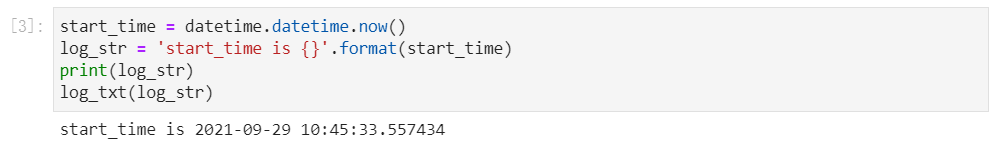

In [ ]:
city_list = ['C48FDFBFC4072E0E','AFE97F546A10368F','EA5EAA705108BDA0','F37F452354AC87C9']
timestamp_column = "TimeStamp"
userlabel_column = "UserLabel"
G4_data_columns = ['上行利用率PUSCH','下行利用率PDSCH', '有效RRC连接平均数', '下行流量', '上行流量', '下行利用率PDCCH']
G5_data_columns = ['上行利用率PUSCH','下行利用率PDSCH', '有数据传输的RRC数', '下行流量', '上行流量', '下行利用率PDCCH']
time_format = "%Y-%m-%d %H:%M:%S"
data_col_dict = {'上行利用率PUSCH':'PUSCH','下行利用率PDSCH':'PDSCH','有效RRC连接平均数':'RRC',
                             '下行流量':'PDCPDL','上行流量':'PDCPUL','下行利用率PDCCH':'PDCCH','有数据传输的RRC数':'RRC'}
n_steps = 168
n_pred = 168

In [ ]:
def pic_to_pd(file_path,select_data_column,float_type):
    print('begin to get data from {}'.format(file_path))
    file=open(file_path,'rb')
    df = pickle.load(file)
    file.close()
    select_columns = ["TimeStamp","UserLabel"]
    select_columns.append(select_data_column)
    df= df[select_columns]
    df.dropna(inplace = True)
    df.reset_index(drop = True,inplace = True)
    df[select_data_column] = df[select_data_column].astype(float_type)
    return df

**Compare with 004 step,here is no matrixing transformation to make the training and prediction become n*24 hrs time sliding windows mode**

**与004step比较，接下来没有做n*24小时滑窗模式矩阵变换**

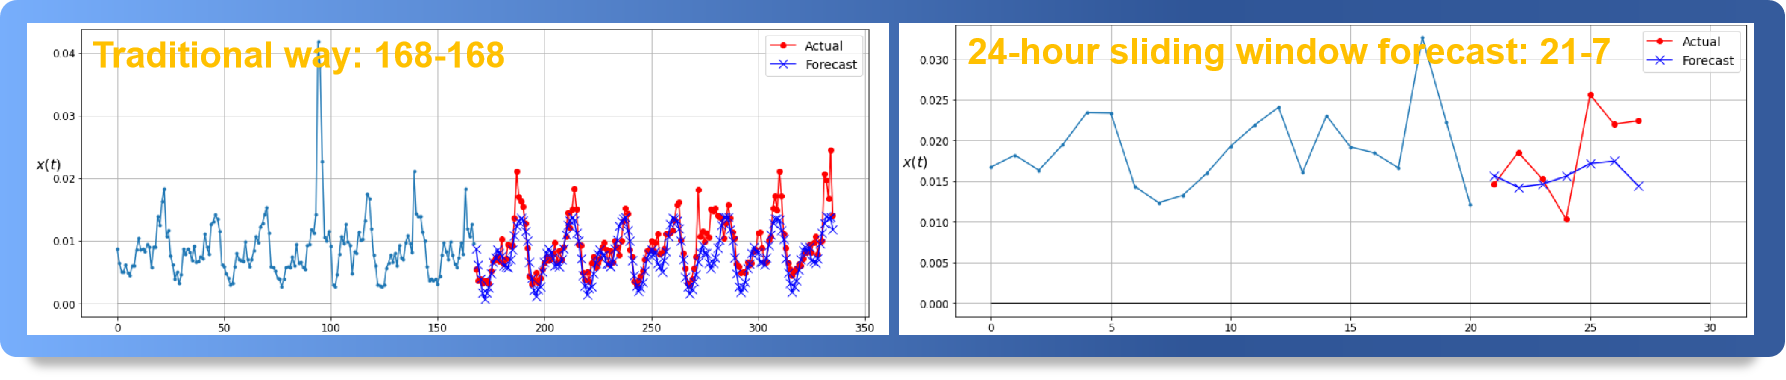

In [ ]:
def pd_to_npdata(df,n_steps,n_pred,select_data_column,data_select_radio,select_cell_list):
    print('begin to trun pandas data to train and test data')
    user_num = len(df["UserLabel"].unique())
    #time_num = len(df["TimeStamp_orgin"].unique())
    #df.sort_values(["TimeStamp_orgin","UserLabel"],inplace = True)
    time_num = len(df["TimeStamp"].unique())
    #df.sort_values(["TimeStamp","UserLabel"],inplace = True)
    df.reset_index(drop = True,inplace = True)
    print('before select cell the user_num is{}'.format(user_num))
    print('before select cell the time_num is{}'.format(time_num))
    #生成X_test
    end_test_row = len(df)-(n_steps * user_num)
    X_test = df.loc[end_test_row:,select_data_column].values.reshape(n_steps,user_num).T.reshape(user_num,n_steps,1)
    index_X_test = df.loc[end_test_row:end_test_row + user_num - 1,["TimeStamp","UserLabel"]]
    #重新选择部分小区
    df = df.query("UserLabel in {}".format(select_cell_list))
    df.reset_index(drop = True,inplace = True)
    user_num = len(df["UserLabel"].unique())
    time_num = len(df["TimeStamp"].unique())
    print('after select cell the user_num is{}'.format(user_num))
    print('after select cell the time_num is{}'.format(time_num))
    print('begin to trun pandas data to train and test data')
    df.reset_index(drop = True,inplace = True)
    print("need turn time_order to {}".format(time_num - n_steps - n_pred + 1))
    X_train_list = []
    Y_train_list = []
    index_Y_train_list = []
    for time_order in range(0,time_num - n_steps - n_pred + 1,data_select_radio):
        print("now time_order is {}".format(time_order))
        start_row = time_order * user_num
        end_x_low = start_row + n_steps * user_num - 1
        end_y_low = end_x_low + n_pred * user_num
        X_train_list.append(df.loc[start_row:end_x_low,select_data_column].values.reshape(n_steps,user_num).T.reshape(user_num,n_steps,1))
        Y_train_list.append(df.loc[end_x_low + 1:end_y_low,select_data_column].values.reshape(n_pred,user_num).T.reshape(user_num,n_pred))
        index_Y_train_list.append(df.loc[end_x_low + 1:end_x_low + user_num,["TimeStamp","UserLabel"]])
    X_train = np.concatenate(X_train_list, axis=0)
    del(X_train_list)
    Y_train = np.concatenate(Y_train_list, axis=0)
    del(Y_train_list)
    index_Y_train = pd.concat(index_Y_train_list)
    del(index_Y_train_list)
    return X_train,Y_train,index_Y_train,X_test,index_X_test

In [ ]:
def all_data_scaler(data_list,scale_param_in = False):
    print('begin to scaler data')
    data_shape_list = []
    for i in range(len(data_list)):
        data_shape_list.append(np.array(data_list[i]).shape)
        data_list[i] = np.array(data_list[i]).reshape(-1,1)
        if i==0:
            if scale_param_in == False:
                scaler = MinMaxScaler()
                scale_param = scaler.fit(data_list[0])
            else:
                scale_param = scale_param_in
        data_list[i] = scale_param.transform(data_list[i])
        data_list[i] = data_list[i].reshape(data_shape_list[i])
    return(data_list,scale_param)

In [ ]:
def train_data_dump(file_path,data_list):
    file=open(file_path,"wb")
    for orgin_data in data_list:
        pickle.dump(orgin_data,file)
    file.close()

In [ ]:
def train_data_load(file_path,file_num = 6):
    data_list = []
    file=open(file_path,'rb')
    for data_order in range(file_num):
        data_list.append(pickle.load(file))
    file.close()
    return data_list

In [ ]:
def creat_mape_handel(low_discrete = 0.01 ,high_discrete = 1):
    def mape_handel(y_true, y_pred):
        error = y_pred - y_true
        mape_error_handel = tf.abs(error) / tf.clip_by_value(y_true,low_discrete,high_discrete)
        return mape_error_handel
    return mape_handel

In [ ]:
in_file = "./Datasets/cell_choose_11000new.pic"
file=open(in_file,"rb")
select_cell_dict_train = pickle.load(file)
file.close()

In [ ]:
for net_type in ['4g','5g']:
    if net_type == '4g':
        gselect_data_columns = ['上行利用率PUSCH','下行利用率PDSCH', '有效RRC连接平均数', '下行流量', '上行流量', '下行利用率PDCCH']
    else:
        gselect_data_columns = ['上行利用率PUSCH','下行利用率PDSCH', '有数据传输的RRC数', '下行流量', '上行流量', '下行利用率PDCCH']
    for city_name in city_list:
        in_file = './Datasets_new_IQR_100/{}_pm_202106_{}.pic'.format(net_type,city_name)
        for select_data_column in gselect_data_columns:
            result_data_path = './result_data_168/{}_{}_{}.csv'.format(net_type,data_col_dict[select_data_column],city_name)
            print('begin to create {}'.format(result_data_path))
            if os.path.exists(result_data_path):
                print('there is already file {} exists'.format(result_data_path))
                continue
            out_file = "./temple_file/train_test_data_{}_{}_{}_168.pic".format(net_type,city_name,select_data_column)
            print('begin to create {}'.format(out_file))
            if os.path.exists(out_file):
                print('there is already file {} exists'.format(out_file))
                X_train,Y_train,X_test,scale_param,index_Y_train,index_X_test = train_data_load(out_file)
            else:
                print('begin to prapare data to train')
                #float_type = data_float_dict[select_data_column]
                float_type = 'float32'
                df = pic_to_pd(in_file,select_data_column,float_type)
                #data_select_radio = study_radio_dict[net_type][city_name]
                data_select_radio = 24
                X_train,Y_train,index_Y_train,X_test,index_X_test =  pd_to_npdata(df,n_steps,n_pred,select_data_column,data_select_radio,
                                                                                  select_cell_dict_train[net_type][city_name])
                del(df)
                [X_train,Y_train,X_test],scale_param = all_data_scaler([X_train,Y_train,X_test])
                #train_data_dump(out_file,[X_train,Y_train,X_test,scale_param,index_Y_train,index_X_test])
                print('{} data dump success'.format(out_file))
            scale_median = np.median(X_train)
            #ins_low = np.percentile(X_train,10)
            #ins_low = scale_median/4
            log_str = 'scale_median is {}'.format(scale_median)
            print(log_str)
            #log_str = 'ins_low is {}'.format(ins_low)
            #print(log_str)
            #Y_train[Y_train < ins_low] = ins_low
            X_train_dnn, X_valid_dnn = train_test_split(X_train, test_size=0.3, random_state=2012)
            Y_train_dnn, Y_valid_dnn = train_test_split(Y_train, test_size=0.3, random_state=2012)
            del(X_train)
            del(Y_train)
            Y_pred_copy = X_valid_dnn[:,:,0].copy()
            Y_true_sub = Y_valid_dnn.copy()
            simple_mse = np.mean(keras.losses.mean_squared_error(Y_true_sub, Y_pred_copy))
            log_str = 'The simple_mse of {}_{}_{} is {}. Time:{}'.format(net_type,city_name,select_data_column,
                                                                        simple_mse,datetime.datetime.now())
            print(log_str)
            log_txt(log_str)
            Y_pred_copy[Y_true_sub == 0] = 0.01
            Y_true_sub[Y_true_sub == 0] = Y_pred_copy[Y_true_sub == 0]
            simple_mape = np.mean(keras.losses.mape(Y_true_sub, Y_pred_copy))
            log_str = 'The simple_mape of {}_{}_{} is {}. Time:{}'.format(net_type,city_name,select_data_column,
                                                                        simple_mape,datetime.datetime.now())
            print(log_str)
            log_txt(log_str)
            log_txt('-'*88)
            model_file_path = "./temple_file/{}_{}_{}_model_wave168.h5".format(net_type,select_data_column,city_name)
            if os.path.exists(model_file_path):
                print('there is already file {} exists'.format(model_file_path))
                model = keras.models.load_model(model_file_path,
                                                custom_objects = {'creat_mape_handel':creat_mape_handel(scale_median,1),
                                                                 'mape_handel':mape_handel()})
            else:
                patience_select = int(11000 / len(select_cell_dict_train[net_type][city_name]) * 3)
                print("patience_select is {}".format(patience_select))
                epochs_select = int(11000 / len(select_cell_dict_train[net_type][city_name])* 25)
                print("epochs_select is {}".format(epochs_select))
                np.random.seed(42)
                tf.random.set_seed(42)
                model = keras.models.Sequential()
                model.add(keras.layers.InputLayer(input_shape=[None, 1]))
                for rate in (1, 2, 4, 8, 16, 32) * 2:
                    model.add(keras.layers.Conv1D(filters=84, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
                model.add(keras.layers.Conv1D(filters=168, kernel_size=1,activation="relu"))
                model.add(keras.layers.Reshape((168, 168)))
                model.add(keras.layers.Flatten())
                model.add(keras.layers.Dense(n_pred))
                checkpoint_cb = keras.callbacks.ModelCheckpoint(model_file_path,save_best_only=True)
                early_stopping_cb = keras.callbacks.EarlyStopping(patience=patience_select,
                                                                  restore_best_weights=True)
                model.compile(loss="mae", optimizer="adam")
                history = model.fit(X_train_dnn, Y_train_dnn, epochs=epochs_select,
                                    validation_data=(X_valid_dnn, Y_valid_dnn),
                                    callbacks = [checkpoint_cb, early_stopping_cb])
            Y_pred_sub = model.predict(X_valid_dnn)
            simple_mse = np.mean(keras.losses.mean_squared_error(Y_valid_dnn, Y_pred_sub))
            log_str = 'The line_mse of {}_{}_{} is {}. Time:{}'.format(net_type,city_name,select_data_column,
                                                                        simple_mse,datetime.datetime.now())
            print(log_str)
            log_txt(log_str)
            Y_true_sub = Y_valid_dnn.copy()
            Y_pred_copy = Y_pred_sub.copy()
            Y_pred_copy[Y_true_sub == 0] = 0.01
            Y_true_sub[Y_true_sub == 0] = Y_pred_copy[Y_true_sub == 0]
            simple_mape = np.mean(keras.losses.mape(Y_true_sub, Y_pred_copy))
            log_str = 'The line_mape of {}_{}_{} is {}. Time:{}'.format(net_type,city_name,select_data_column,
                                                                        simple_mape,datetime.datetime.now())
            print(log_str)
            log_txt(log_str)
            log_txt('='*88)
            Y_test = model.predict(X_test)
            Y_pred = scale_param.inverse_transform(Y_test.reshape(-1,1)).reshape(Y_test.shape)
            columns_name = []
            for order_num in range(1,169):
                columns_name.append("预测未来{}小时".format(order_num))
            sub_data = pd.DataFrame(Y_pred,columns = columns_name,index = index_X_test.UserLabel)
            sub_data.index.name = "UserLabel"
            #指标数据不可能小于0，剔除异常预测
            sub_data[sub_data < 0] = 0
            print("begin output_data in {}".format(result_data_path))
            sub_data.to_csv(result_data_path,encoding= 'gbk')
            print("success output_data in {}".format(result_data_path))
            keras.backend.clear_session()
            del(sub_data,X_train_dnn, X_valid_dnn,Y_train_dnn, Y_valid_dnn, Y_pred, X_test, Y_test)
            del(index_Y_train,index_X_test)
            if os.path.exists(out_file):  # 如果文件存在
                # 删除文件，可使用以下两种方法。
                os.remove(out_file)
                # os.unlink(path)
            else:
                print('no such file:%s' % out_file)  # 则返回文件不存在

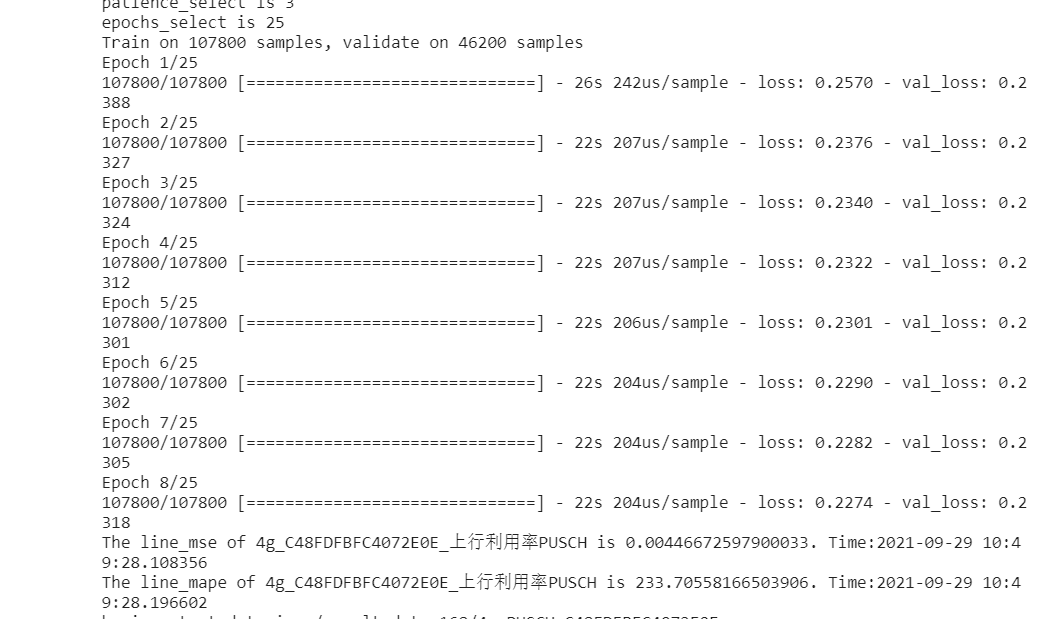截图23

In [ ]:
end_time = datetime.datetime.now()
log_str = 'end_time is {}'.format(end_time)
print(log_str)
log_txt(log_str)
all_use_time = (end_time - start_time)
log_str = 'all_use_time is {}'.format(all_use_time)
print(log_str)
log_txt(log_str)

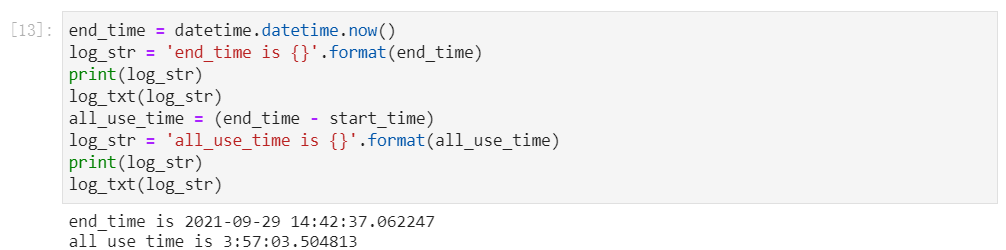

In [ ]:
import zipfile

In [ ]:
def compressFolder(folderPath, compressPathName):
    '''
    :param folderPath: 文件夹路径
    :param compressPathName: 压缩包路径
    :return:
    '''
    zip = zipfile.ZipFile(compressPathName, 'w', zipfile.ZIP_DEFLATED)
    for path, dirNames, fileNames in os.walk(folderPath):
        for name in fileNames:
            fullName = os.path.join(path, name)
            name = "result_data" + '/' + name
            print(fullName)
            print(name)
            zip.write(fullName, name)

    zip.close()

In [ ]:
folderPath = './result_data_168'
compressPathName = './result_data.zip'
compressFolder(folderPath, compressPathName)

In [ ]:
!curl --location --request POST 'http://36.133.53.121:1080/file/upload' --form 'cloud_id=CIDC-U-6fca7a4e9f9645f0abe69ea1df9f7e26' --form 'file=@result_data.zip'

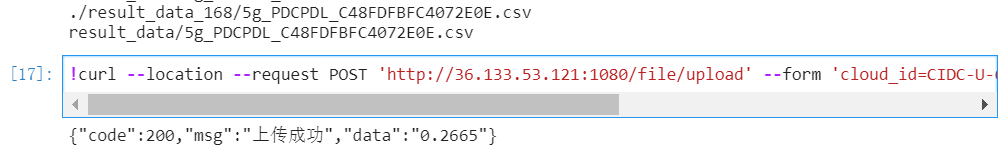